In [58]:
import numpy as np
import matplotlib.pyplot as plt
#to read image
from PIL import Image

In [59]:
def create_gaussian_kernel(kernel_size,sigma):
  kernel=np.fromfunction(lambda x, y: (1/ (2 * np.pi * sigma ** 2)) *
        np.exp(-((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (kernel_size, kernel_size))
  #normalise
  return kernel/np.sum(kernel)

In [60]:
def gaussian_blur(image,kernel_size,sigma):
  #make kernel
  kernel=create_gaussian_kernel(kernel_size,sigma)
  #create empty blurred image
  blurred_image=np.zeros_like(image,dtype=np.float64)

  #define padding
  padding=kernel_size//2
  padded_image=np.pad(image,((padding,padding),(padding,padding)),mode='constant')
  #now the original image is padded

  for i in range(padding, padded_image.shape[0] - padding):
        for j in range(padding, padded_image.shape[1] - padding):
            patch = padded_image[i - padding:i + padding + 1, j - padding:j + padding + 1]
            blurred_image[i - padding, j - padding] = np.sum(patch * kernel)

  return blurred_image.astype(np.uint8)

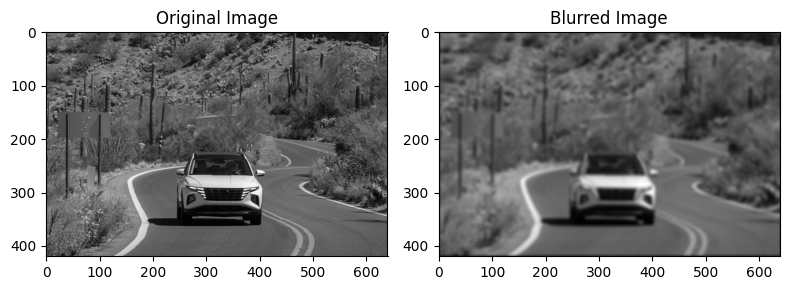

In [61]:
#apply and save
file_path = "/content/car.jpg"
image = np.array(Image.open(file_path).convert('L'))  # Convert to grayscale

# Apply Gaussian blur to the image
kernel_size = 11
sigma = 3
blurred_image = gaussian_blur(image, kernel_size, sigma)

# Display the original and blurred images
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(122)
plt.title('Blurred Image')
plt.imshow(blurred_image, cmap='gray')

plt.tight_layout()
plt.show()

# Save the blurred image as a PNG file
output_file_path = "blurred2_image.png"  # Specify the desired file path
Image.fromarray(blurred_image).save(output_file_path)

#sharpen this image


using unsharp masking formula

In [62]:
amount=0.1
difference=blurred_image-image
sharpened_image=blurred_image + amount*difference
sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)


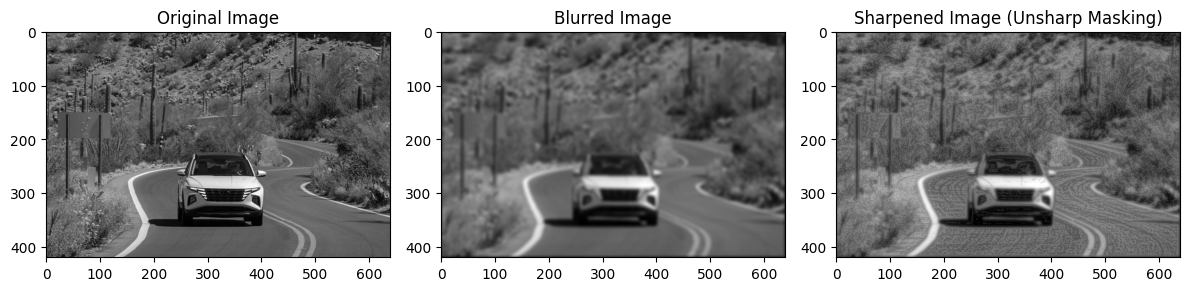

In [63]:
# Display the original, blurred, and sharpened images
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(132)
plt.title('Blurred Image')
plt.imshow(blurred_image, cmap='gray')

plt.subplot(133)
plt.title('Sharpened Image')
plt.imshow(sharpened_image, cmap='gray')

plt.tight_layout()
plt.show()

#detecting edges

detect edges in x and y and combine them , its like using 2 kernels
and combining their results

In [68]:
from scipy.signal import convolve2d

In [69]:
image = np.array(Image.open('/content/car.jpg').convert('L'))

In [70]:
image_array = np.array(image)

In [71]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


In [72]:
gradient_x = convolve2d(image_array, sobel_x, mode='same', boundary='symm')
gradient_y = convolve2d(image_array, sobel_y, mode='same', boundary='symm')


In [74]:
# the magnitude of the gradient
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255

In [75]:
edge_image = gradient_magnitude.astype(np.uint8)

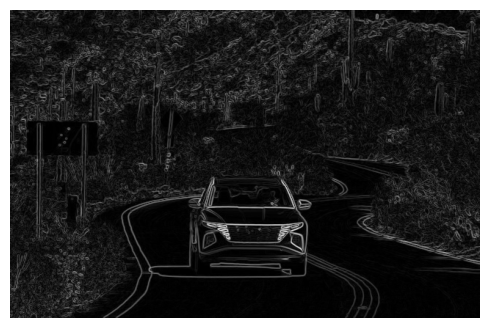

In [78]:
plt.figure(figsize=(12, 4))
plt.imshow(edge_image, cmap='gray')
plt.axis('off')
plt.show()

#noise addition

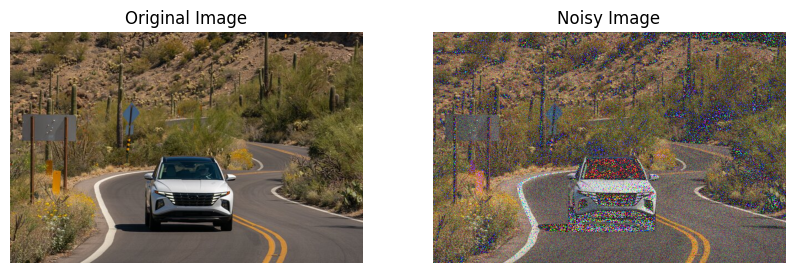

In [83]:

image = Image.open('/content/car.jpg')


image_array = np.array(image)

# Define noise parameters
mean = 0  # Mean of the Gaussian distribution
stddev = 25  # Standard deviation of the Gaussian distribution (controls noise intensity)

# Generate Gaussian noise with the same dimensions as the image
noise = np.random.normal(mean, stddev, image_array.shape).astype(np.uint8)

# Add the noise to the image
#The np.clip function is used to ensure that the resulting pixel values stay within the valid range of 0 to 255. This step prevents pixel values from going beyond the valid range.
noisy_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)

# Display the noisy image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.show()

#denoising

In [87]:
noisy_image_array = np.array(noisy_image)

# Define the filter size (kernel size)
kernel_size = 3


#Median Filter: It applies a median filter, which is a specific type of spatial filter used for denoising and smoothing images.
#The median filter replaces each pixel's value with the median value of its neighborhood, making it effective at removing salt-and-pepper noise and preserving edges.
def median_filter_channel(channel, kernel_size):
    height, width = channel.shape
    filtered_channel = np.zeros((height, width), dtype=np.uint8)

    # Iterate over each pixel in the channel
    for i in range(height):
        for j in range(width):
            # Extract the neighborhood centered at (i, j)
            neighborhood = channel[max(0, i - kernel_size // 2):min(height, i + kernel_size // 2 + 1),
                                  max(0, j - kernel_size // 2):min(width, j + kernel_size // 2 + 1)]

            # Apply median filter to the neighborhood and set the filtered pixel value
            filtered_channel[i, j] = np.median(neighborhood)

    return filtered_channel



In [88]:
# Apply the median filter to each color channel independently
r_channel = noisy_image_array[:, :, 0]
g_channel = noisy_image_array[:, :, 1]
b_channel = noisy_image_array[:, :, 2]

denoised_r = median_filter_channel(r_channel, kernel_size)
denoised_g = median_filter_channel(g_channel, kernel_size)
denoised_b = median_filter_channel(b_channel, kernel_size)




In [89]:
# Combine the denoised color channels into an RGB image
denoised_image_array = np.stack((denoised_r, denoised_g, denoised_b), axis=-1)

# Convert the denoised image array back to an image
denoised_image = Image.fromarray(denoised_image_array)

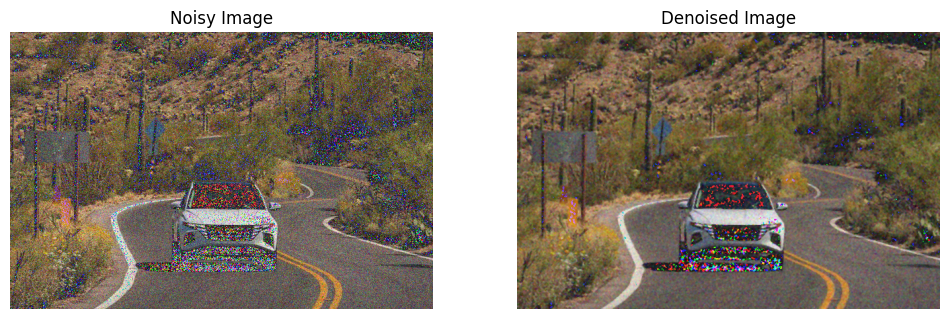

In [90]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image_array)
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image_array)
plt.title('Denoised Image')
plt.axis('off')

plt.show()